# Reference implementation  of GW 

The purpose of this notebook is two-fold. First, it is meant to give an outline of the working equations and implementation of the simplest approximation within GW family, i.e. $G_0W_0$@HF/DFT, and some of its extensions. Second, it provides a playground for testing new reduced-cost GW algorithms such as SPA or optimized virtual space approach of Bruneval et al. The theory and algorithms behind the code can be found in the papers:

1. Bruneval, F., Rangel, T., Hamed, S. M., Shao, M., Yang, C., & Neaton, J. B. (2016). molgw 1: Many-body perturbation theory software for atoms, molecules, and clusters. Computer Physics Communications, 208, 149–161. https://doi.org/10.1016/J.CPC.2016.06.019

2. van Setten, M. J., Weigend, F., & Evers, F. (2013). The GW -Method for Quantum Chemistry Applications: Theory and Implementation. Journal of Chemical Theory and Computation, 9(1), 232–246. https://doi.org/10.1021/ct300648t

3. Bruneval, F. (2012). Ionization energy of atoms obtained from GW self-energy or from random phase approximation total energies. The Journal of Chemical Physics, 136(19), 194107. https://doi.org/10.1063/1.4718428

4. Dreuw, A., Head-Gordon, M. (2005). Single-Reference ab Initio Methods for the Calculation of Excited States of Large Molecules. https://doi.org/10.1021/CR0505627

## Working equations of GW method

GW approximation can be derived from Hedin equations by substituting vertex function $\Gamma$ for the product of the two delta functions $\Gamma = \delta(1-2) \delta(2-3)$ (i stands for a combined coordinate $(r_i, t_i)$. Upon substitution Hedin equations assume the followign form:

$$
G(1,2) = G_H(1,2) + \int d(34) G_H(1,3) \Sigma(3,4) G(4,2) \\
\Sigma(1,2) = i G(1, 2) W(1, 2^{+})\\
W(1,2) = v(1,2) + \int d(34) v(1,3) P(3,4) W(4,2)\\
P(1,2) = -i G(1,2) G(2,1^{+})
$$

"+" indicates choronological ordering (e.g. $t_1^{+} = t_1 + \eta$, $\eta \to 0$).
Screened Coulomb interaction W(1,2) can be expressed in terms of the full density response function $\chi$:

$$
W(1,2) = v(1,2) + \int d(34) v(1,3) \chi(3,4) v(4,2)
$$

Note that (unscreened) Coulomb interaction is assumed to be instanteneous, i.e. $v(1,2) = \delta(t_1 - t_2) 1/|r_1 - r_2|$ (shorthand notation: $ v(r_1,r_2)\delta(t_1 - t_2)$), therefore, the last equation can be written explicitly in terms of the integrals over spatial coordinates only:

$$
W(1,2) = v(r_1,r_2)\delta(t_1 - t_2)  + \int d(r_3r_4) v(r_1,r_3) \chi(r_3,r_4; t_1 - t_2) v(r_4,r_2)
$$

In frequency domain the equation for the self-energy is transfomed as follows (note the error in [2]):

$$
\Sigma(r_1,r_2, \omega) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} e^{i\xi \eta} G(r_1, r_2, \omega + \xi) W(r_1, r_2, \xi) d\xi,
$$
where $\eta \to 0+$. Combining previous equation with the expression for screened Coulomb interaction one obtains:

$$
\Sigma(r_1,r_2, \omega) = \frac{i}{2\pi} v(r_1, r_2) \int_{-\infty}^{+\infty} e^{i\xi \eta} G(r_1, r_2, \omega + \xi) d\xi +  \frac{i}{2\pi} \int_{-\infty}^{+\infty} d \xi \int d(r_3r_4) e^{i\xi \eta} G(r_1, r_2, \omega + \xi) v(r_1,r_3) \chi(r_3,r_4; \xi) v(r_4,r_2) 
$$

The first contribution can be readily recognized as an **exchange** part of the self-energy as $-\rho(r_1, r_2) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} e^{i\xi \eta} G(r_1, r_2, \xi) d\xi$ is one particle density matrix. The remaining part is due to correlation. Diagrammatically, the last equation is represented as:

![Diagrammatic representation of self-energy in GW](hedin_diag.png)

Full density response is calculated at RPA/TDDFT level by solving Casida equation:

$$ \begin{bmatrix}A & B\\-B & -A\end{bmatrix} \begin{bmatrix}X_s\\Y_s\end{bmatrix} = \omega_s \begin{bmatrix}X_s\\Y_s\end{bmatrix}, $$

where (for spin-resticted case) $A_{ia, jb} = \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) + (ia|jb) - c_{HF} (ij|ab) + (1-c_{HF})(ia|f_{xc}|jb)$ and $B_{ia, jb} = (ia|bj) - c_{HF} (ib|aj) + (1-c_{HF})(ia|f_{xc}|bj)$. Once all the solutions of Casida equation are found (see below for more detail), the matrix elements of W can be expressed as follows:

$$
W_{mn\sigma_1, op\sigma_2} = (mn\sigma_1|op\sigma_2) + \sum_s \omega_{mn\sigma_1}^{s}\omega_{op\sigma_2}^{s} \times \big( \frac{1}{\omega - \Omega_s + i\eta} -  \frac{1}{\omega + \Omega_s - i\eta} \big), 
$$

where $\omega_{mn\sigma_1}^{s} = \sum_{ia\sigma}(mn\sigma_1|ia\sigma)(X_{ia\sigma}^{s} + Y_{ia\sigma}^{s})$. The product basis representation of screened Coulomb interaction is then contracted with zero-order Kohn-Sham one-particle Green's function to give self-energy (as shown above):

$$
G_{\sigma\sigma\prime}^{KS}(r_1, r_2, \omega) = \delta_{\sigma\sigma\prime} \sum_k \frac{\phi_{k\sigma}(r_1)\phi_{k\sigma}^{*}(r_2) }{\omega - \epsilon_{k\sigma} + i\eta \times sign(\epsilon_{k\sigma} - \mu)}
$$



The integrals over $\xi$ can be performed analytically (the integration contour is closed in the upper half-plane):

$$
\int_{-\infty}^{+\infty} \frac{d\xi e^{i\xi \eta}}{(\xi + \omega - \epsilon_{k\sigma} + i\eta \times sign(\epsilon_{k\sigma} - \mu))(\xi - \Omega_s + i\eta)} = \begin{cases} 0 &\mbox{if } \epsilon_{k\sigma} > \mu\\
-\frac{2\pi i}{\omega - \epsilon_{k\sigma} + \Omega_s - 2i\eta} &\mbox{otherwise }\end{cases}
$$

$$
\int_{-\infty}^{+\infty} \frac{d\xi e^{i\xi \eta}}{(\xi + \omega - \epsilon_{k\sigma} + i\eta \times sign(\epsilon_{k\sigma} - \mu))(\xi + \Omega_s - i\eta)} = \begin{cases} \frac{2\pi i}{\omega - \epsilon_{k\sigma} - \Omega_s + 2i\eta} &\mbox{if } \epsilon_{k\sigma} > \mu\\
0 &\mbox{otherwise }\end{cases}
$$

The GW self-energy can, therefore, be written in terms of tensor contractions:

$$
\Sigma_{nn\sigma}(\omega) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} d \xi e^{i\xi \eta} \Sigma_i \frac{W_{ni\sigma, in\sigma}(\xi)}{\xi + \omega - \epsilon_{i\sigma} - i\eta} + \Sigma_a \frac{W_{na\sigma, an\sigma}(\xi)}{\xi + \omega - \epsilon_{a\sigma} + i\eta}\\
=-\Sigma_i (ni\sigma|in\sigma) + \Sigma_{is} \frac{\omega_{ni\sigma}^s\omega_{in\sigma}^s}{\omega - \epsilon_{i\sigma} + \Omega_s - 2i\eta} + \Sigma_{as} \frac{\omega_{na\sigma}^s\omega_{an\sigma}^s}{\omega - \epsilon_{a\sigma} - \Omega_s + 2i\eta}
$$


If one takes into account that $G^{KS-1} = G^{H-1} + V_{xc}$, diagonal approximation for the inverse Dyson equation assumes the following form:

$$
\omega = \epsilon_{n\sigma} - \langle n\sigma | V_{xc}^{\sigma} | n\sigma \rangle + \Sigma_{nn\sigma}^{xc}(\omega)
$$

In [2]:
import psi4
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# Set up the test molecule & the basis set

#h2o = psi4.geometry("""O   0.0000000 0.0000000 -0.0644484
#                       H   0.7499149 0.0000000 0.5114912
#                       H  -0.7499149 0.0000000 0.5114912
#                       symmetry c1
#""")

h2o = psi4.geometry("""O   0.000000000000  -0.143225816552   0.000000000000 
                       H   1.638036840407   1.136548822547  -0.000000000000
                       H  -1.638036840407   1.136548822547  -0.000000000000
                       symmetry c1
                       units bohr
""")

# Set SCF options (convergence criteria for the density matrix and energy) and basis set 

#psi4.set_options({'basis' : 'sto-3g', 'd_convergence' : 1e-8, 'e_convergence' : 1e-9 })
psi4.set_options({'basis' : 'sto-3g', 'd_convergence' : 1e-7 })

# run scf

psi4.set_output_file('h2o_sto.out')

# Obtain converged energy and WaveFunction object

en, wfn = psi4.energy('hf', molecule=h2o, return_wfn=True)
print("SCF energy is %16.10f" % en)

# Make sure that we are using pure aungular momentum functions (same as MolGW)

assert wfn.basisset().has_puream()

SCF energy is   -74.9421761261


SCF energy from MOLGW  -74.9420799282

The calculation was performed using the following input file
```
&molgw
 scf='HF'

 basis='STO-3G'
 gaussian_type='pure'
 print_restart='no'
 print_bigrestart='yes'
 read_restart='yes'

 length_unit='bohr'

 frozencore='no'

 postscf='G0W0'
 selfenergy_state_range=4
 nomega_sigma=501
 step_sigma=0.01
 natom = 3

 integral_quality='insane'
 tolscf=1e-7
/
8   0.000000000000  -0.143225816552   0.000000000000
1   1.638036840407   1.136548822547  -0.000000000000
1  -1.638036840407   1.136548822547  -0.000000000000

```

For closed shell reference (i.e., alpha and beta orbitals are the same) A, B matrices will have the block structure shown below:

$$
 \begin{bmatrix}C^{\alpha\alpha} & C^{\alpha\beta}\\C^{\beta\alpha} & C^{\beta\beta}\end{bmatrix},
$$

where $C^{\alpha\alpha} = C^{\beta\beta}$ and $C^{\alpha\beta} = C^{\beta\alpha}$. The symmetry relations between the blocks can be utilized to further simplify the RPA eigenvalue problem by applying the unitary transformation $\mathbf{U}$ which decouples singlet and triplet excitations:

$$
\mathbf{U} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 & 0 & 0\\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1 \end{bmatrix} 
$$

$$ \begin{bmatrix}A^{+} & 0 & B^{+} & 0\\0 & A^{-} & 0 & B^{-} \\ -B^{+} & 0 & -A^{+} & 0 \\ 0 & -B^{-} & 0 & -A^{-}\end{bmatrix} \begin{bmatrix}X^{+}_s\\ X^{-}_s \\Y^{+}_s\\ Y^{-}_s \end{bmatrix} = \omega_s \begin{bmatrix}X^{+}_s\\ X^{-}_s \\Y^{+}_s\\ Y^{-}_s \end{bmatrix}, $$

where $A^{\pm} = A^{ss} \pm A^{os}$ and $B^{\pm} =  B^{ss} \pm B^{os}$. "ss" and "os" stand for "same spin" and "opposite spin", respectively. Explicit expressions for the matrix elements from the definitions of A, B matrices:

$$
A_{ia, jb}^{+} = \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) + 2(ia|jb) - c_{HF} (ij|ab) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} + f_{xc}^{\alpha\beta}|jb)\\
B_{ia, jb}^{+} = 2(ia|bj) - c_{HF} (ib|aj) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} + f_{xc}^{\alpha\beta}|bj)\\
A_{ia, jb}^{-} = \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) -c_{HF} (ij|ab) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} - f_{xc}^{\alpha\beta}|jb)\\
B_{ia, jb}^{-} = -c_{HF} (ib|aj) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} - f_{xc}^{\alpha\beta}|bj)
$$

The eigenvectors of the original eigenvalue problem are modified: $V^{\pm}_s = \frac{1}{\sqrt{2}}(V^{\alpha}_s \pm V^{\beta}_s)$. The block structure of the eigenvalue problem allows solving for "+" and "-" components of the eigenvectors separately. Moreover, since we are interested in $X^{+} + Y^{+}$ (they are required to construct $\omega$ tensors, see above) we can solve the "+" eigenvalue problem only. 
For simplicity current implementation uses HF reference ($c_{HF} = 1$); that is supposed to produce RPA/TDHF screening, however, Bruneval's implementation of RPA screening discards exchange contributions to A and B matrices. In order to facilitate comparison we will follow the same approach here. 


In [8]:
from numpy import linalg as LA

In [9]:
# Extract HF data from Psi4 

# Orbital coefficients 

C = wfn.Ca()
Co = wfn.Ca_subset("AO", "OCC")
Cv = wfn.Ca_subset("AO", "VIR")
epsilon = np.asarray(wfn.epsilon_a())

print("Orbital energies", epsilon)

# Information about orbital spaces

nbf = wfn.nmo()
nocc = wfn.nalpha()
nvir = nbf - nocc

# Transform ERI-s
# Get the integrals from mints helper
# Form oNNN MO tensor, oN^4 cost

mints = psi4.core.MintsHelper(wfn.basisset())
MO = np.asarray(mints.mo_eri(Co, C, C, C))


Orbital energies [-20.26313119  -1.20972369  -0.54797111  -0.43653438  -0.38759806
   0.47761482   0.58814715]


Orbital energies from MOLGW (see above for the input file)

```
 -20.262891615575189       -1.2096973736852064      -0.54796464977809689      -0.43652720205632561      -0.38758671716307996       0.47761872367342073       0.58813928286720241
 ```

In [10]:
epsilon_molgw = np.array([-20.262891615575189,       -1.2096973736852064,      -0.54796464977809689,      -0.43652720205632561,      -0.38758671716307996,       0.47761872367342073,       0.58813928286720241])
print("Differences between MolGW and Psi4 one particle energies for STO-3G water, eV")
print((epsilon - epsilon_molgw)*27.211)

Differences between MolGW and Psi4 one particle energies for STO-3G water, eV
[-0.00651919 -0.00071607 -0.00017592 -0.00019533 -0.00030877 -0.00010615
  0.00021417]


In [12]:
# Calculate A^{+} + B^{+} matrix; Note that A^{+} - B^{+} will be diagonal so we could store just a
# flattened 1D array

# Diagonal \epsilon_a - \epsilon_i
eps_diag = epsilon[nocc:].reshape(-1, 1) - epsilon[:nocc]
assert eps_diag.shape == (nvir, nocc)

# A^{+} + B^{+}
ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * MO[:nocc, nocc:, :nocc, nocc: ]
ApB = ApB.reshape((nocc*nvir, nocc*nvir)) 
# since nD numpy arrays have C-style memroy layout the occupied orbital inedex changes slower than the virtual one

# Diagonal of  A^{+} - B^{+}
AmB_diag = eps_diag.T.reshape((1, -1))
AmB_diag = np.diag(AmB_diag[0,:])

assert AmB_diag.shape == ApB.shape


# Form C matrix (as one usually does when solving RPA eigenvalue problem)
C = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), ApB, np.sqrt(AmB_diag))

# Solve for the excitation energies and calculate X + Y eigenvectors

omega2, Z = LA.eigh(C)
omega = np.sqrt(omega2)
xpy = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), Z, np.diag(1./np.sqrt(omega)))

print(omega)
print("xpy components")

for i in range(len(omega)):
    print(xpy[:,i])

[ 0.93185397  1.00551887  1.0246072   1.05605733  1.2533905   1.42618979
  1.9090891   1.93222014 20.79307735 20.89030158]
xpy components
[ 5.00852937e-18  2.01710603e-17  9.83252384e-16 -1.85924539e-15
 -3.29720369e-15  4.47445404e-15 -7.86705229e-15  8.20483187e-15
 -9.63579517e-01 -5.56187155e-13]
[ 2.43593114e-05  1.57753699e-14  7.48873315e-02 -1.22444732e-12
  8.04698268e-12  3.78626047e-01  8.89238062e-01  2.19341422e-12
 -5.49333068e-15 -6.49082571e-14]
[ 8.38644529e-18 -4.24555334e-17  6.07708449e-15  1.99010982e-15
 -1.19689342e-14  3.57492160e-14  5.42098408e-14  4.57222600e-15
 -4.99472575e-13  9.75864486e-01]
[-7.87832963e-15 -1.58436963e-03  1.40589105e-12  9.06285941e-02
 -6.86150775e-01  6.72989402e-12  4.77674574e-12 -7.03719125e-01
 -3.16725157e-15 -4.96777906e-15]
[-1.03236668e-14 -1.09358322e-03 -5.43950296e-13 -2.91688097e-02
  6.46537446e-01 -1.37420892e-12 -3.34907321e-12 -6.31981598e-01
 -6.38233658e-15  1.03963252e-14]
[ 1.60060904e-03 -8.49019972e-15  3.281721

The values should be compared to those produced by **MolGW** code for the same geometry & basis:

0.93184532974707635        
1.0055084957782070        
1.0245854271826726        
1.0560497534213935        
1.2533735998089335         
1.4261666879014583        
1.9090696520971144        
1.9321796168357281        
20.792841443403219         
20.890052672176569

The corresponding eigenvectors are shown below in the same order:

```
  6.9863451824159508E-020   1.0347903982226666E-018  -2.9025622470217256E-016   1.0380723585650678E-016   2.7263929234128543E-016  -1.1782370664958697E-015  -2.1498300574174335E-015   6.0057889311452796E-016 -0.96357983850259821       -3.7314048283888026E-015
  
  -2.4261027736339349E-005  -7.1095753105462959E-017   7.4894099673548015E-002  -4.9467843830327603E-015   3.4687286906195304E-014  0.37861147419427094      -0.88924558697934708       -1.5849462091845140E-014   1.5136339234680844E-015   4.1910119296874737E-015
  
   6.5175773962394187E-019  -1.0614634197634954E-017  -3.6213382540575118E-016  -5.2790639681214681E-016   3.7595512502261316E-015  -2.2464865144450436E-015   3.5228433826904579E-015   3.4084850122608640E-016  -3.4763942434291611E-015  0.97586524614766490
   
  -2.7834530498884836E-017  -1.5844276502780816E-003  -6.1881742879964130E-015  -9.0630358288245311E-002  0.68612519521145188       -3.0195654921668668E-014   2.4639353671834610E-014 -0.70374279442573628       -2.1636775548365216E-016  -2.3119515410361461E-015
  
  -4.6408885746309042E-017  -1.0935121373124590E-003   3.1165744605453759E-015   2.9184934275236021E-002 -0.64656449529955373        1.8080518079416433E-015  -1.1744450860941047E-014 -0.63195677061250999       -4.8524841367940961E-016   2.5903239129272817E-015
  
  -1.6005736868649782E-003   4.2451090563513115E-016  0.32818722058415062       -5.7777718158433598E-015  -7.6678671299386434E-015 -0.80036434946331436      -0.25921856701018070        1.2003156266379920E-014   1.2374213889016850E-015  -5.1536387989793920E-016
  
  -1.4371805921492373E-003   0.0000000000000000       0.89466491075699794        7.4931357364761550E-014   8.3509705866533483E-015  0.20263644243329729       0.11024343747783723       -5.6582648124584247E-015  -5.5871166035061717E-016   1.6825498913046119E-016
  
  -6.6921042323401402E-017   3.6223394873181160E-003   6.7597661891427018E-014 -0.96199158031094956       -4.8054074149431379E-002   1.9823199835295589E-014   1.0285277815509811E-014   2.3799931147865751E-002  -4.8907365502246725E-017  -1.1451913753804269E-016
  
  0.99874063197990903        2.8939818631576795E-015   1.5436512184212437E-004   4.1415390655103708E-018  -7.5481055647420987E-019  -6.0759632988568325E-005  -1.4972785324155803E-005  -2.3715933199626943E-018   6.7374419681595644E-020  -6.0689173406349240E-020
  
   2.8793479336020364E-015 -0.99906487684782552        3.1552856855136100E-017  -3.1725823260642902E-004  -2.8662987465628249E-005  -2.5891039893402435E-017  -1.4515374447580972E-017   1.0590295291496288E-004  -1.2074723188178976E-020  -5.3183196903279015E-019
```

In GW@HF the QP equation is modified due to cancellation of the exchange term:
$$
\omega = \epsilon_{n\sigma} + \Sigma_{nn\sigma}^{c}(\omega),
$$
where $\Sigma_{nn\sigma}^{c}(\omega) = \Sigma_{is} \frac{\omega_{ni\sigma}^s\omega_{in\sigma}^s}{\omega - \epsilon_{i\sigma} + \Omega_s - 2i\eta} + \Sigma_{as} \frac{\omega_{na\sigma}^s\omega_{an\sigma}^s}{\omega - \epsilon_{a\sigma} - \Omega_s + 2i\eta}$ and $\omega_{mn\sigma_1}^{s} = \sum_{ia}(mn\sigma_1|ia)(X_{ia}^{+s} + Y_{ia}^{+s})$. Note that the expression for omega tensor was adapted by performing summation over the spin label and accounting for the symmetry between $\alpha$ and $\beta$ orbitals.

Newton iteration of the QP equation assumes the following simple form:
$$
\omega_{k+1}  = \epsilon_{n\sigma} + Z_{n\sigma}(\omega_k) \Sigma_{nn\sigma}^{c}(\omega_k)
$$

$Z_{n\sigma}(\omega_k)$ is a pole strength defined as $Z_{n\sigma}(\omega_k) = (1 - \frac{d\Sigma_{nn\sigma}^{c}}{d\omega}|_{\omega = \omega_{k}})^{-1}$. In terms of real quantities:

$$
Re \omega_{k+1} = \epsilon_{n\sigma} + Re Z_{n\sigma}(\omega_k)  Re \Sigma_{nn\sigma}^{c}(\omega_k) - Im Z_{n\sigma}(\omega_k) Im \Sigma_{nn\sigma}^{c}(\omega_k)\\
Im \omega_{k+1} = Im Z_{n\sigma}(\omega_k)  Re \Sigma_{nn\sigma}^{c}(\omega_k) + Re Z_{n\sigma}(\omega_k) Im \Sigma_{nn\sigma}^{c}(\omega_k)
$$

In [16]:
# Some parameters of the GW calculation

no_qp = nocc     # Number of hole states 
nv_qp = 0        # Number of particle states
eta = 1e-3       # Eta value as recommended by F. Bruneval
ndyson_iter = 30 # Number of iterations used to solve the inverse Dyson equation
e_conv = 1e-6    # Convergence criterion for the QP energy, a.u.
molgw_lin = True # Calculate MolGW style one-shot G0W0 

# Conversion factor from E_h to eV

Ha2eV = 27.21138505


# Start by creating intermediates
# Self-energy denominators; those are of two kinds

Dis = -epsilon[:nocc].reshape((-1, 1)) + omega 
Das = -epsilon[nocc:].reshape((-1, 1)) - omega 

# Omega tensors; This will be refactored to improve memory efficiency

i_rtia = np.einsum("iart->rtia", MO[:,nocc:,:,:]) 
i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))

# Note the sqrt(2); it appears because of the connection between X + Y and xpy (see the transformation matrix U)

omega_rts = np.sqrt(2.) * np.einsum("rtk, ks->rts", i_rtia, xpy)
assert omega_rts.shape == (nbf, nbf, len(omega))

# Setup all the necessary arrays and start iteration; 
# for efficiency reasons (minimize cache miss) it is beneficial to perform the Newton iteration for all the quasiparticles simultaneously

qp_en = epsilon[:no_qp + nv_qp] + 1.j * np.zeros(no_qp + nv_qp)
qp_molgw_lin = np.zeros(qp_en.shape[0])

#Dis_1 = np.zeros((no_qp + nv_qp, nocc, len(sqrtOmega)), dtype=complex)
#for i in range(no_qp + nv_qp):
#    for j in range(nocc):
#        for k in range(len(omega)):
#            Dis_1[i, j, k] = qp_en[i] + Dis[j, k]
#
#Dis_ = Dis + qp_en.reshape((no_qp + nv_qp, 1, 1)) 
#assert np.allclose(Dis_, Dis_1)

# Convergence flag

dyson_converged = False

for it in range(ndyson_iter):
    #Dis_ = Dis + qp_en.reshape((no_qp + nv_qp, 1, 1)) - 2.j*eta
    #Das_ = Das + qp_en.reshape((no_qp + nv_qp, 1, 1)) + 2.j*eta
    
    Dis_ = Dis + qp_en.reshape((no_qp + nv_qp, 1, 1)) - 1.j*eta
    Das_ = Das + qp_en.reshape((no_qp + nv_qp, 1, 1)) + 1.j*eta
    
    assert Dis_.shape == (no_qp + nv_qp, nocc, len(omega))
    assert Das_.shape == (no_qp + nv_qp, nvir, len(omega))

    # Contribution due to occupied orbitals
    Sigma_c = np.einsum("kis, kis, kis->k", omega_rts[:no_qp + nv_qp,:nocc,:], 1./Dis_, omega_rts[:no_qp + nv_qp,:nocc,:])
    # Contribution due to virtuals
    Sigma_c +=  np.einsum("kas, kas, kas->k", omega_rts[:no_qp + nv_qp,nocc:,:], 1./Das_, omega_rts[:no_qp + nv_qp,nocc:,:])
    # Pole strengths
    Z = np.einsum("kis, kis, kis->k", omega_rts[:no_qp + nv_qp,:nocc,:], 1./Dis_**2, omega_rts[:no_qp + nv_qp,:nocc,:])
    Z += np.einsum("kas, kas, kas->k", omega_rts[:no_qp + nv_qp,nocc:,:], 1./Das_**2, omega_rts[:no_qp + nv_qp,nocc:,:])
    Z = 1. / (1. + Z) 
    # Calculate MolGW style QP G0W0 energies via linearization the inverse Dyson equation
    if it == 0 and molgw_lin:
        qp_molgw_lin = epsilon[:no_qp + nv_qp] + Z.real * Sigma_c.real
    # New qp energies
    new_qp_en = epsilon[:no_qp + nv_qp] + Z * Sigma_c
    
    # Check convergence 
    max_diff = np.max(np.abs(new_qp_en.real - qp_en.real))
    
    if max_diff < e_conv:
        dyson_converged = True
        qp_en = np.copy(new_qp_en)
        break
    else:
        qp_en = np.copy(new_qp_en)
        
if not dyson_converged:
    print("Newton iteration for QP equation has not converged in %d iterations..." % (ndyson_iter))
else:
    print("Iterative solution of QP equation has converged!")
    
print("E(HF), eV  E(GW), eV  E(MOLGW G0W0 lin), eV")
for i in range(no_qp + nv_qp):
    print("%13.6f  %13.6f  %13.6f\n" % (epsilon[i] * Ha2eV, qp_en[i].real * Ha2eV, qp_molgw_lin[i] * Ha2eV))
    

Iterative solution of QP equation has converged!
E(HF), eV  E(GW), eV  E(MOLGW G0W0 lin), eV
  -551.387865    -545.992910    -545.508956

   -32.918257     -30.565721     -30.525403

   -14.911053     -14.982980     -14.984813

   -11.878705     -11.095465     -11.065531

   -10.547080      -8.692699      -8.616510



MolGW reference values are below (please compare E(GW) to E_qp^lin):
```
GW eigenvalues (eV)
           E0         SigX-Vxc       SigC          Z        E_qp^lin     E_qp^graph
           
   1   -551.381346     0.000000     6.782279     0.866806  -545.502424  -545.403738
   
   2    -32.917541     0.000000     3.658711     0.652532   -30.530115   -30.134722
   
   3    -14.910877     0.000000    -0.075641     0.974568   -14.984595   -14.984590
   
   4    -11.878510     0.000000     0.847035     0.960160   -11.065221   -11.064759
   
   5    -10.546771    -0.000000     2.025241     0.953254    -8.616202    -8.612335
```

It can be observed that the one-shot G0W0 method (as implemented here) tends to give results that are very close to E_qp^lin. However, since MolGW calculates the pole strength using a 3-point finite difference expression (as opposed to analytic formula used in this notebook) the agreement is not perfect. In order to check that explicitly, we present implementation of both linearized and graphical solutions of the QP equation that are identical to those found in MolGW. Some relevant Fortran code snippets are shown below (please refer to *m_selfenergy_tools.f90* for details); their Python equivalents can be found in the following notebook cell.

**Linearized**

```
subroutine find_qp_energy_linearization(se,exchange_m_vxc,energy0,energy_qp_z,zz)
 implicit none

 type(selfenergy_grid),intent(in) :: se
 real(dp),intent(in)              :: exchange_m_vxc(:,:),energy0(:,:)
 real(dp),intent(out)             :: energy_qp_z(:,:)
 real(dp),intent(out),optional    :: zz(:,:)
!=====
 integer  :: nstate
 integer  :: pstate,pspin
 real(dp) :: zz_p(nspin)
!=====

 nstate = SIZE(exchange_m_vxc,DIM=1)

 ! First, a dummy initialization
 energy_qp_z(:,:) = energy0(:,:)

 ! Then overwrite the interesting energy with the calculated GW one
 !$OMP PARALLEL
 !$OMP DO PRIVATE(pspin,zz_p)
 do pstate=nsemin,nsemax

   if( se%nomega > 0 .AND. PRESENT(zz) ) then
     zz_p(:) = REAL( se%sigma(1,pstate,:) - se%sigma(-1,pstate,:) ,dp) / REAL( se%omega(1) - se%omega(-1) ,dp)
     zz_p(:) = 1.0_dp / ( 1.0_dp - zz_p(:) )
     ! Constrain Z to be in [0:1] to avoid crazy values
     ! Z falls out of [0:1] when a weak self-energy pole is very close to Eks.
     ! Z out of [0:1] is an indicator for whether it happened or not.
     do pspin=1,nspin
       zz_p(pspin) = MIN( MAX(zz_p(pspin),0.0_dp) , 1.0_dp )
     enddo

     zz(pstate,:)          = zz_p(:)
     energy_qp_z(pstate,:) = se%energy0(pstate,:)  &
             + zz_p(:) * ( energy0(pstate,:) - se%energy0(pstate,:)  &
                            + REAL(se%sigma(0,pstate,:),dp) + exchange_m_vxc(pstate,:) )

   else

     energy_qp_z(pstate,:) = energy0(pstate,:) + REAL(se%sigma(0,pstate,:),dp) + exchange_m_vxc(pstate,:)

   endif

 enddo
 !$OMP END DO
 !$OMP END PARALLEL

end subroutine find_qp_energy_linearization

```

**Graphical**

```
subroutine find_qp_energy_graphical(se,exchange_m_vxc,energy0,energy_qp_g)
 implicit none

 type(selfenergy_grid),intent(in) :: se
 real(dp),intent(in)  :: exchange_m_vxc(:,:),energy0(:,:)
 real(dp),intent(out) :: energy_qp_g(:,:)
!=====
 integer,parameter :: NFIXED_POINTS_MAX = 4
 integer  :: nfixed,ifixed
 integer  :: nstate,pstate,pspin
 real(dp) :: energy_fixed_point(NFIXED_POINTS_MAX,nsemin:nsemax,nspin),z_weight(NFIXED_POINTS_MAX,nsemin:nsemax,nspin)
 real(dp) :: equation_lhs(-se%nomega:se%nomega),equation_rhs(-se%nomega:se%nomega)
!=====

 nstate = SIZE(exchange_m_vxc,DIM=1)
 write(stdout,'(/,1x,a)') 'Graphical solution to the QP equation'
 write(stdout,'(1x,a,sp,f8.3,a,f8.3)') 'Scanning range around the input energy (eV): ', &
                              REAL(se%omega(-se%nomega),dp)*Ha_eV,'  --',REAL(se%omega(se%nomega),dp)*Ha_eV
 write(stdout,'(1x,a,i6)')             'Number of discretization points:             ',SIZE(se%omega(:))

 ! First, a dummy initialization
 energy_qp_g(:,:) = 0.0_dp
 z_weight(:,:,:)  = 0.0_dp
 energy_fixed_point(:,:,:) = 0.0_dp

 ! Then overwrite the interesting energy with the calculated GW one
 do pstate=nsemin,nsemax

   if( MODULO(pstate-nsemin,nproc_world) /= rank_world ) cycle

   do pspin=1,nspin
     !
     ! QP equation:
     ! E_GW = E0 + \omega =  E_gKS + \Sigma_c(E0+\omega) + \Sigma_x - v_xc
     !
     equation_lhs(:) = REAL(se%omega(:),dp)+se%energy0(pstate,pspin)
     equation_rhs(:) = REAL(se%sigma(:,pstate,pspin),dp) + exchange_m_vxc(pstate,pspin) + energy0(pstate,pspin)
     call find_fixed_point(equation_lhs,equation_rhs,energy_fixed_point(:,pstate,pspin),z_weight(:,pstate,pspin))

     ! If no reasonable QP energy found, then set E_qp to E_gKS for safety
     if( z_weight(1,pstate,pspin) < 1.0e-6_dp ) then
       energy_qp_g(pstate,pspin) = energy0(pstate,pspin)
     else
       energy_qp_g(pstate,pspin) = energy_fixed_point(1,pstate,pspin)
     endif

   enddo

 enddo

 call xsum_world(energy_qp_g)
 call xsum_world(z_weight)
 call xsum_world(energy_fixed_point)

 ! Master IO node outputs the solution details
 write(stdout,'(/,1x,a)') 'state spin    QP energy (eV)  QP spectral weight'
 do pstate=nsemin,nsemax
   do pspin=1,nspin
     nfixed = COUNT( z_weight(:,pstate,pspin) > 0.0_dp )
     if( nfixed > 0 ) then
       write(stdout,'(1x,i5,2x,i3,*(3x,f12.6,3x,f12.6))') pstate,pspin, &
                 ( energy_fixed_point(ifixed,pstate,pspin)*Ha_eV,z_weight(ifixed,pstate,pspin), ifixed = 1,nfixed)
     else
       write(stdout,'(1x,i5,2x,i3,a)') pstate,pspin,'      has no graphical solution in the calculated range'
     endif
   enddo
 enddo

 if( ANY(z_weight(1,:,:) < 0.0_dp) ) then
   call issue_warning('At least one state had no graphical solution in the calculated range.'  &
                   // ' Increase nomega_sigma or step_sigma.')
 endif

 ! Unchanged energies for the states that were not calculated (outside range [nsemin:nsemax])
 energy_qp_g(:nsemin-1,:) = energy0(:nsemin-1,:)
 energy_qp_g(nsemax+1:,:) = energy0(nsemax+1:,:)

end subroutine find_qp_energy_graphical

subroutine find_fixed_point(xx,fx,energy_fixed_point,z_weight)
 implicit none
 real(dp),intent(in) :: xx(:)
 real(dp),intent(in) :: fx(:)
 real(dp),intent(out) :: energy_fixed_point(:),z_weight(:)
!=====
 integer  :: nx,ix
 integer  :: nfpmx,ifixed,jfixed
 real(dp) :: gx(SIZE(xx))
 real(dp) :: gpxi
 real(dp) :: z_zero
 integer  :: enumerate(SIZE(energy_fixed_point))
!=====

 nx = SIZE(xx)
 nfpmx = SIZE(energy_fixed_point)
 do ifixed=1,nfpmx
   enumerate(ifixed) = ifixed
 enddo

 ! Negative value to indicate something bad happened
 z_weight(:)           = -1.0_dp
 energy_fixed_point(:) =  0.0_dp

 !
 ! g(x) contains f(x) - x
 gx(:) = fx(:) - xx(:)
 ifixed = 0

 do ix=1,nx-1
   ! Check for sign changes => fixed point
   if( gx(ix) * gx(ix+1) < 0.0_dp ) then
     ! Evaluate the weight Z of the pole
     !  Z = ( 1 - d\Sigma / d\omega )^-1
     !  Z should be in [0,1]
     z_zero = 1.0_dp / ( 1.0_dp - ( fx(ix+1) - fx(ix) ) / ( xx(ix+1) - xx(ix) ) )

     ! Z not valid
     if( z_zero < 0.00001_dp ) cycle
     ! Compare the new Z with the largest Z's found at this stage
     if( z_zero > z_weight(nfpmx) ) then

       jfixed = MINVAL( enumerate(:), z_zero > z_weight(:) )
       z_weight(jfixed+1:nfpmx)           = z_weight(jfixed:nfpmx-1)
       energy_fixed_point(jfixed+1:nfpmx) = energy_fixed_point(jfixed:nfpmx-1)
       z_weight(jfixed) = z_zero
       gpxi = ( gx(ix+1) - gx(ix) ) / ( xx(ix+1) - xx(ix) )
       energy_fixed_point(jfixed) = xx(ix) - gx(ix) / gpxi

     endif

   endif
 enddo

end subroutine find_fixed_point

```


In [66]:
# parameters of the self-energy calculation

nomega_sigma = 501
step_sigma = 0.01

# create an array of sampling frequencies similar to MolGW

nomega_grid = nomega_sigma // 2 # note this is a truncation (aka integer) division
omega_grid = np.array(range(-nomega_grid, nomega_grid + 1)) * step_sigma

# sampling energies for all the states so we could calculate the self-energy matrix (broadcasting)

omega_grid_all = omega_grid + epsilon[:no_qp + nv_qp].reshape((-1, 1))
assert omega_grid_all.shape == (no_qp + nv_qp, 2*nomega_grid + 1)

#Calculate denominators

Dis_ = Dis + omega_grid_all.reshape((no_qp + nv_qp, 2*nomega_grid + 1, 1, 1)) - 1.j*eta
Das_ = Das + omega_grid_all.reshape((no_qp + nv_qp, 2*nomega_grid + 1, 1, 1)) + 1.j*eta

# self-energy matrix (with the shape (no_qp + nv_qp, 2*nomega_grid + 1))

# Contribution due to occupied orbitals (note that the shape of the structure of the denominator array is not optimal)
Sigma_c_grid = np.einsum("kis, klis, kis->kl", omega_rts[:no_qp + nv_qp,:nocc,:], 1./Dis_, omega_rts[:no_qp + nv_qp,:nocc,:])
# Contribution due to virtuals
Sigma_c_grid +=  np.einsum("kas, klas, kas->kl", omega_rts[:no_qp + nv_qp,nocc:,:], 1./Das_, omega_rts[:no_qp + nv_qp,nocc:,:])

# Calculate Sigma_c__ for an arbitrary orbital of your choice and make sure that Sigma_c_grid contains the same result
orbi = nocc - 1 

oorb = omega_grid + epsilon[orbi]
Dis__ = Dis + oorb.reshape((2*nomega_grid + 1, 1, 1)) - 1.j*eta
Das__ =  Das + oorb.reshape((2*nomega_grid + 1, 1, 1)) + 1.j*eta

Sigma_c__ = np.einsum("is, lis, is->l", omega_rts[orbi,:nocc,:], 1./Dis__, omega_rts[orbi,:nocc,:])
# Contribution due to virtuals
Sigma_c__ +=  np.einsum("as, las, as->l", omega_rts[orbi,nocc:,:], 1./Das__, omega_rts[orbi,nocc:,:])

assert np.allclose(Sigma_c__, Sigma_c_grid[orbi, :])

# quick check to see if the result is reasonable - plot selfenergy for the HOMO

#plt.plot( oorb * Ha2eV, Sigma_c_grid[orbi, :].real * Ha2eV)

# OK, keeping my nose to the grindstone:
# Algorithm #1 : linearization of the self-energy

qp_molgw_lin_ = np.zeros(no_qp + nv_qp)

# Calculate pole strengths by performing numerical derivative on the omega grid

zz = np.real(Sigma_c_grid[:, nomega_grid + 1] - Sigma_c_grid[:, nomega_grid - 1]) / (omega_grid[nomega_grid + 1] - omega_grid[nomega_grid - 1])
zz = 1. / (1. - zz)
zz[zz <= 0.0] = 0.0
zz[zz >= 1.0] = 1.0

qp_molgw_lin_ = epsilon[:no_qp + nv_qp] + zz * np.real(Sigma_c_grid[:, nomega_grid])

#print(qp_molgw_lin_ * Ha2eV)

# Algorithm #2 : graphical solution of the QP equation 
# both rhs and lhs of the QP equation have been calculated above; we need to define the solver function

qp_molgw_graph_ = np.copy(epsilon[:no_qp + nv_qp])
zz_graph = np.zeros(no_qp + nv_qp)

def find_fixed_point(lhs, rhs):
    # This function returns an array of fixed points and correspoinding pole strengths
    # Its application can be vectorized using strandard NumPy np.vectorize
    
    assert lhs.shape == rhs.shape
    
    # Maximum number of fixed points (same as in MolGW)
    nfp_max = 4
    
    # Pole strength threshold
    pthresh = 1e-5
    
    # Arrays of f.p. energies and  Z
    zfp = np.zeros(nfp_max)
    zfp[:] = -1.0
    efp = np.zeros(nfp_max)
    
    # Auxiliary index array
    idx = np.arange(nfp_max)
    
    n = len(lhs)
    ifixed = 0
    g = rhs - lhs
    
    # loop over grid points excluding the last one
    
    for i in range(n - 1):
        if g[i] * g[i + 1] < 0.0:
            #print("Fixed point found betwenn %13.6f and %13.6f eV! " % (lhs[i] * Ha2eV, lhs[i+1] * Ha2eV))
            z_zero = 1. / ( 1. - ( g[i+1] - g[i] ) / ( lhs[i+1] - lhs[i] ) )
            if z_zero < pthresh:
                continue
            # Do some bookkeeping; the code looks ugly but that is exactly what F.Bruneval has in MolGW package
            
            if z_zero > zfp[-1]:
                jfixed = np.min(idx[z_zero > zfp])
                zfp[jfixed + 1:] = zfp[jfixed:nfp_max - 1]
                efp[jfixed + 1:] = efp[jfixed:nfp_max - 1]
                zfp[jfixed] = z_zero
                # Perfom linear interpolation to find the root
                zeta = (g[i + 1] - g[i]) / (lhs[i + 1] - lhs[i])
                efp[jfixed] = lhs[i] - g[i] / zeta
    
    #print("Graphical solver concluded operation")
    return (zfp, efp)

# Perform loop over QP states 

for state in range(no_qp + nv_qp):
    z , e = find_fixed_point(omega_grid_all[state], np.real(Sigma_c_grid[state, :]) + epsilon[state])
    if z[0] < 1e-6:
        print("Graphical solver failed for state %d" % (state + 1))
        # Do nothing since the array cell already contains HF orbital energy
    else:
        qp_molgw_graph_[state] = e[0]
        zz_graph[state] = z[0]
    
# Print QP energies and compare them with MolGW reference values

qp_molgw_linref = np.array([-545.502424, -30.530115, -14.984595, -11.065221, -8.616202])
elin = np.abs(qp_molgw_linref - Ha2eV * qp_molgw_lin_)
qp_molgw_graphref = np.array([-545.403738, -30.134722, -14.984590, -11.064759, -8.612335])
egraph = np.abs(qp_molgw_graphref - Ha2eV * qp_molgw_graph_)
z_molgw_ref = np.array([0.866806, 0.652532, 0.974568, 0.960160, 0.953254])

print("Error analysis of the linearized solution")
print("E^lin, eV  E^lin (MOLGW), eV  AbsError, eV  Z  Z (MolGW)")
for i in range(no_qp + nv_qp):
    print("%13.6f  %13.6f  %13.6f %13.6f  %13.6f" % (qp_molgw_lin_[i]*Ha2eV, qp_molgw_linref[i], elin[i], z_molgw_ref[i], zz[i]))
    
print("Error analysis of the graphical solution")
print("E^graph, eV  E^graph (MOLGW), eV  AbsError, eV")
for i in range(no_qp + nv_qp):
    print("%13.6f  %13.6f  %13.6f " % (qp_molgw_graph_[i]*Ha2eV, qp_molgw_graphref[i], egraph[i] ))

print("Error analysis of the zero order (HF) QP energies")
print("E^hf, eV  E^hf (MOLGW), eV  AbsError, eV")
eorb = np.abs(epsilon - epsilon_molgw) * Ha2eV
for i in range(no_qp + nv_qp):
    print("%13.6f  %13.6f  %13.6f " % (epsilon[i]*Ha2eV, epsilon_molgw[i] * Ha2eV, eorb[i]))


Error analysis of the linearized solution
E^lin, eV  E^lin (MOLGW), eV  AbsError, eV  Z  Z (MolGW)
  -545.508990    -545.502424       0.006566      0.866806       0.866807
   -30.530798     -30.530115       0.000683      0.652532       0.652517
   -14.984812     -14.984595       0.000217      0.974568       0.974569
   -11.065532     -11.065221       0.000311      0.960160       0.960161
    -8.616514      -8.616202       0.000312      0.953254       0.953254
Error analysis of the graphical solution
E^graph, eV  E^graph (MOLGW), eV  AbsError, eV
  -545.410307    -545.403738       0.006569 
   -30.135357     -30.134722       0.000635 
   -14.984808     -14.984590       0.000218 
   -11.065071     -11.064759       0.000312 
    -8.612646      -8.612335       0.000311 
Error analysis of the zero order (HF) QP energies
E^hf, eV  E^hf (MOLGW), eV  AbsError, eV
  -551.387865    -551.381346       0.006519 
   -32.918257     -32.917541       0.000716 
   -14.911053     -14.910877       0.00017

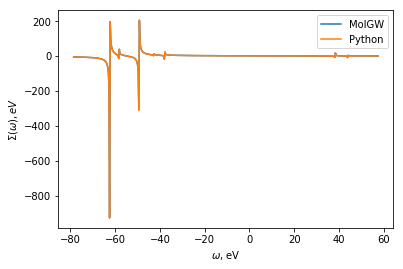

In [67]:
import pandas as pd

# Compare the real parts of self-energy from MolGW with Sigma_c_grid. 
# They should match almost perfectly as they were obtained at the same sampling points and with the
# same eta

# read reference data from selfenergy file written by MolGW
se = pd.read_table('selfenergy_GW_state005.dat', header=0, sep='\s+')
plt.plot(se['omega'], se['ReSigmaC(eV)'], label='MolGW')


orbital_index = 4 # HOMO
plt.plot(Ha2eV * omega_grid_all[orbital_index], Ha2eV * Sigma_c_grid[orbital_index,:].real, label='Python')

plt.xlabel('$\omega$, eV')
plt.ylabel('$\Sigma(\omega), eV$')
plt.legend()

# The following function is provided for convenience

def Sigma_on_grid(omega_grid, o):
    
    # The function calculates the real part of 
    # the oo diagonal element of self-energy 
    # on a grid in frequency domain
    
    omega_grid = np.asarray(omega_grid)
    Dis_ = Dis + omega_grid.reshape((-1, 1, 1)) - 1.j*eta
    Das_ = Das + omega_grid.reshape((-1, 1, 1)) + 1.j*eta
    
    # Contribution due to occupied orbitals
    Sigma_c = np.einsum("is, kis, is->k", omega_rts[o,:nocc,:], 1./Dis_, omega_rts[o,:nocc,:])
    # Contribution due to virtuals
    Sigma_c +=  np.einsum("as, kas, as->k", omega_rts[o,nocc:,:], 1./Das_, omega_rts[o,nocc:,:])
    
    return Sigma_c.real



## Bethe - Salpeter equation

The theory in this section if based on the Bruneval's Comm Phys Comm paper [1] as well as on the lecture notes of Prof. Julien Toulouse (Laboratoire de Chimie Théorique, Sorbonne Université & CNRS, Paris, France) [Introduction to many-body Green-function theory](http://www.lct.jussieu.fr/pagesperso/toulouse/enseignement/introduction_green.pdf)


Bethe-Salpeter equation (BSE) is a Dyson type equation connecting a four point linear response function $\chi(1, 2; 1^{\prime}, 2^{\prime}, \omega)$ of a fully interacting system with that of a non-interacting system (in space-time domain):

$$
\chi(1, 2; 1^{\prime}, 2^{\prime}) = \chi_0(1, 2; 1^{\prime}, 2^{\prime}) + \int d3d4d5d6 \chi_0(1, 4; 1^{\prime}, 3, \omega) \Xi(3,6;4,5) \chi(5, 6; 2, 2^{\prime}),
$$

where the response function ($\chi$) is defined in terms of one- and two-particle Green's functions  $i\chi(1, 2; 1^{\prime}, 2^{\prime}) =  i^2 G_2(1, 2; 1^{\prime}, 2^{\prime}) - iG(1, 2) iG(1^{\prime}, 2^{\prime})$ and the BSE kernel $\Xi(3,6;4,5)$ is the functional derivative of the self-energy with respect to the one-particle Green's function:

$$
\Xi(1,2;1^{\prime},2^{\prime}) = i\frac{\delta \Sigma(1, 1^{\prime})}{ \delta G(2^{\prime}, 2)}
$$

If self energy is evaluated within GW approximation, it is not hard to obtain an explicit expression for the BSE kernel:

$$
\Xi(1,2;1^{\prime},2^{\prime}) = i\delta(1 - 2^{\prime}) \delta(1^{\prime} - 2) W(1,1^{\prime+})
$$

# TODO

1. Resolution of identity calculation of $\omega_{mn}^{s}$ tensors
2. General implementation of GW@DFT (so that it can be used for spin-polarized systems, i.e. UKS reference)
3. Bethe-Salpeter equation for excitation energies (in progress)